## GeoAI-Enhanced Community Detection on Spatial Networks with Graph Deep Learning

References: <br>
Liang, Y., Zhu, J., Ye, W., & Gao, S. (2022, November). [Region2Vec: community detection on spatial networks using graph embedding with node attributes and spatial interactions](https://dl.acm.org/doi/abs/10.1145/3557915.3560974). In Proceedings of the 30th International Conference on Advances in Geographic Information Systems (ACM SIGSPATIAL),  (pp. 1-4). <br>

Liang, Y., Zhu, J., Ye, W., & Gao, S. (2025). [GeoAI-enhanced community detection on spatial networks with graph deep learning](https://www.sciencedirect.com/science/article/pii/S0198971524001571?dgcid=author). Computers, Environment and Urban Systems, 117, 102228. 

![region2vec](../Region2Vec_Workflow.jpg)


### Environment Setting with the geoai kernel

In [7]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from utils import load_widata, purge
from models import GCN
import csv
import os
import math

# optional for taining loss ploting
import matplotlib.pyplot as plt


# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=500,
                    help='Number of epochs to train.')
parser.add_argument('--patience', type=int, default=50,
                    help='Early stopping control.')
parser.add_argument('--ltype', type=str, default='divreg',
                    help='divide or loglike with regularization.')
parser.add_argument('--lr', type=float, default=0.001,     
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--output', type=int, default=14,
                    help='Output dim.')
parser.add_argument('--dropout', type=float, default=0.1,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--hops', type=float, default=5,
                    help='Contrain with hops')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()
print('Is GPU avaiable:', args.cuda)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


Is GPU avaiable: False


In [ ]:
## Unzip all the data files into the /data/ folder.

from zipfile import ZipFile
with ZipFile('../data.zip', 'r') as zf:
    zf.extractall('../')
print('Unzip data finished')

### Train the region2vec model to generate the neural embeddings of the nodes

Loading wi dataset...
divreg
Epoch: 0000 loss_train: 1.62881 time: 0.4254s
Epoch: 0001 loss_train: 1.61475 time: 0.4139s
Epoch: 0002 loss_train: 1.62739 time: 0.3981s
Epoch: 0003 loss_train: 1.61066 time: 0.3936s
Epoch: 0004 loss_train: 1.60073 time: 0.3974s
Epoch: 0005 loss_train: 1.58269 time: 0.3996s
Epoch: 0006 loss_train: 1.57899 time: 0.4002s
Epoch: 0007 loss_train: 1.55083 time: 0.3984s
Epoch: 0008 loss_train: 1.56946 time: 0.3166s
Epoch: 0009 loss_train: 1.55602 time: 0.4795s
Epoch: 0010 loss_train: 1.55285 time: 0.4020s
Epoch: 0011 loss_train: 1.54309 time: 0.4069s
Epoch: 0012 loss_train: 1.53152 time: 0.3967s
Epoch: 0013 loss_train: 1.51787 time: 0.4021s
Epoch: 0014 loss_train: 1.52130 time: 0.3993s
Epoch: 0015 loss_train: 1.49691 time: 0.4011s
Epoch: 0016 loss_train: 1.50628 time: 0.3978s
Epoch: 0017 loss_train: 1.49850 time: 0.3953s
Epoch: 0018 loss_train: 1.48826 time: 0.4007s
Epoch: 0019 loss_train: 1.47296 time: 0.3973s
Epoch: 0020 loss_train: 1.49481 time: 0.3978s
Epoch

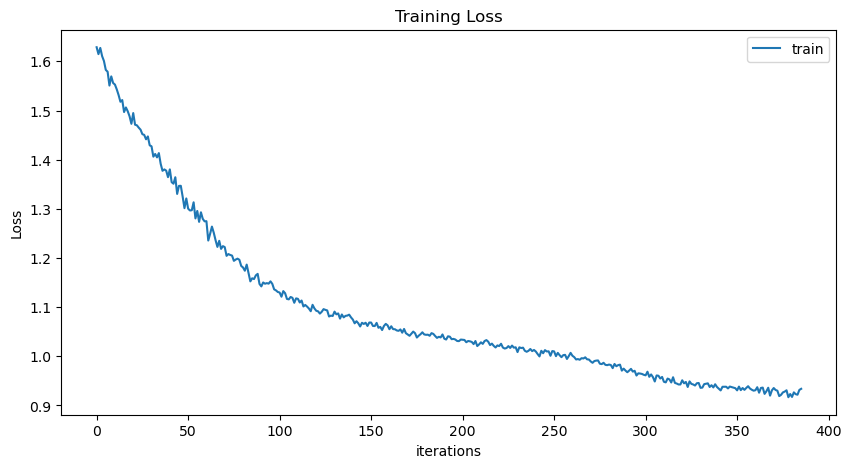

In [ ]:
# Load data
## If you didn't find data files in the folder. Unzip the data.zip compressed file into the 'data' folder first before running this block of code.

adj, features, labels, neg_mask, pos_mask, hops_m, intensity_m_norm, strength = load_widata()
print(args.ltype)

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nout=args.output,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)


EPS = 1e-15

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    neg_mask = neg_mask.cuda()
    pos_mask = pos_mask.cuda()
    hops_m = hops_m.cuda()

N_pos = sum(sum(pos_mask))
N_neg = sum(sum(neg_mask))

# Train model
t_total = time.time()
loss_list = []
for epoch in range(args.epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, output_sfx = model(features, adj) 

    pdist = torch.norm(output[:, None]-output, dim=2, p=2)
    inner_pro = torch.mm(output,output.T)
    loss_hops = 0

# the div loss uses the flow strength directly. It tries to minimize the loss of W_pos*Dist - W_zero*Dist. A larger strength (W_pos) leads to smaller\
#  the distances between embeddings; the W_zero refers nodes with no flow, so their embeddings differences should be as large as possible. 
    if args.ltype == 'div':
        if args.hops > 1:
            loss_hops = torch.sum(pdist.mul(hops_m)) + EPS
        loss_train = torch.sum(pdist.mul(labels).mul(pos_mask)) /( (torch.sum(pdist.mul(neg_mask)) + EPS) + loss_hops)

    elif args.ltype == 'divreg':
        if args.hops > 1:
            loss_hops = torch.sum(pdist.mul(hops_m)) + EPS
        loss_train = torch.sum(pdist.mul(labels).mul(pos_mask))*N_neg /(N_pos*( (torch.sum(pdist.mul(neg_mask)) + EPS) + loss_hops))


    loss_train.backward()
    optimizer.step()

    loss_list.append(loss_train.item())

    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.5f}'.format(loss_train.item()),
          'time: {:.4f}s'.format(time.time() - t))


    result_path = '../result/'
    if not os.path.exists(result_path):
        os.mkdir(result_path)

    if epoch >= 200:
        save_name = 'lr_{}_dropout_{}_hidden_{}_output_{}_patience_{}_hos_{}_losstype_{}_seed_{}.csv'.format(args.lr, args.dropout, args.hidden, args.output, args.patience, args.hops, args.ltype, args.seed)
       
        np.savetxt(result_path + 'Epoch_{}_'.format(epoch) + save_name, output.detach().numpy())

        if epoch > 200 + args.patience and loss_train > np.average(loss_list[-args.patience:]):
            best_epoch = loss_list.index(min(loss_list))
            print('Lose patience, stop training...')
            print('Best epoch: {}'.format(best_epoch))
            purge(result_path, save_name, best_epoch, epoch-best_epoch)
            break

        if epoch == args.epochs -1:
            print('Last epoch, saving...')
            best_epoch = epoch
            purge(result_path, save_name, best_epoch, 0)


print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(loss_list,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Using the generated neural embeddings of the nodes to perform a spatially-constrained clustering to get the Communitty membership

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics


EPS = 1e-15

# running the spatially-constrained agglomerative clustering
def run_aggclustering(path, file_name, affinity, n_clusters, linkage = 'ward'):
    #print(n_clusters)
    X = np.loadtxt(path+file_name, delimiter=' ')
    if 'csv' in file_name:
        file_name = file_name[:-4]

    adj = np.loadtxt('../data/Spatial_matrix_rook.csv', delimiter=',')
    model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters, connectivity = adj, affinity=affinity)

    model.fit(X)
    labels = model.labels_

    homo_score = lwinc_purity(labels)
  
    total_ratio = intra_inter_idx(labels, n_clusters)
    median_ineq = community_inequality(labels, file_name, path, n_clusters)

    median_sim, median_dist = similarity(labels, file_name, path, n_clusters)

    return labels, total_ratio, median_ineq, median_sim, median_dist, homo_score


#generate the homogeneity score
def lwinc_purity(labels, lwinc_file = "../data/feature_matrix_lwinc.csv"):
    X_lwinc = np.loadtxt(lwinc_file, delimiter=',') 
    X_lwinc = X_lwinc[:,1:]
    n_thres = 5
    threshold = np.arange(0, 1+1/n_thres, 1/n_thres)
    lwinc_classes = [np.quantile(X_lwinc, q) for q in threshold] #the classification of lwinc perc
    lwinc_classes[-1] = 1 + EPS #make the upper limit larger than any exsiting values

    X_classes = np.array([next(i-1 for i,t in enumerate(lwinc_classes) if t > v) for v in X_lwinc])

    homo_score = metrics.homogeneity_score(X_classes, labels)
    print("The homogeneity score is {:.3f}".format(homo_score))

    return homo_score
    

def intra_inter_idx(labels, k):
    CIDs = labels
    
    #generate ID to Community ID mapping
    UID = range(0,len(CIDs))
    ID_dict = dict(zip(UID, CIDs))
    
    flow = pd.read_csv('../data/flow_reID.csv')
    if 'Unnamed: 0' in flow.columns:
        flow = flow.drop(columns = 'Unnamed: 0')
        
    flow['From'] = flow['From'].map(ID_dict)
    flow['To'] = flow['To'].map(ID_dict)  
    
    #groupby into communities
    flow_com = flow.groupby(['From','To']).sum(['visitor_flows','pop_flows']).reset_index()
    
    ComIDs = list(flow_com.From.unique())
    intra_flows = list(flow_com[flow_com['From'] == flow_com['To']]['visitor_flows'].values)
    inter_flows = list(flow_com[flow_com['From'] != flow_com['To']].groupby(['From']).sum(['visitor_flows']).reset_index()['visitor_flows'])
    d = {'CID':ComIDs, 'intra': intra_flows, 'inter': inter_flows}
    df = pd.DataFrame(d)
    df['intra_inter'] = df['intra']/df['inter']    

    total_ratio = sum(df['intra'])/sum(df['inter']) 
    print("The total intra/inter ratio is {:.3f}".format(total_ratio))

    return total_ratio


def similarity(labels, file_name, path, n_clusters, savefig = True, feature_path = '../data/feature_matrix_f1.csv'):
    features = np.loadtxt(feature_path, delimiter=',') 
    X = features[:,1:]

    #calculate cos similarity for all features
    cossim_mx = cosine_similarity(X)

    sim_dict = {}
    for c in range(n_clusters):
        ct_com = np.where(labels == c)[0]
        cossim_com = cossim_mx[ct_com[:,None], ct_com[None,:]]  #slice the matrix so all the included values is for this community
        cossim = cossim_com[np.triu_indices(len(ct_com), k = 0)]
        sim_dict[c] = np.mean(cossim)

    median_sim = np.median(list(sim_dict.values()))

    #calculate the euclidean distance for all features
    eucdist_mx = euclidean_distances(X)

    dist_dict = {}
    for c in range(n_clusters):
        ct_com = np.where(labels == c)[0]
        eucdist_com = eucdist_mx[ct_com[:,None], ct_com[None,:]]  #slice the matrix so all the included values is for this community
        eucdist = eucdist_com[np.triu_indices(len(ct_com), k = 0)]
        dist_dict[c] = np.mean(eucdist)

    median_dist = np.median(list(dist_dict.values()))

    print("The median cosine similarity is {:.3f}".format(median_sim))
    print("The median euclidean distance similarity is {:.3f}".format(median_dist))

    return median_sim, median_dist

def cal_inequality(values):
    mean = np.mean(values)
    std = np.std(values)
    ineq = std/math.sqrt(mean*(1-mean))
    return ineq

def community_inequality(labels, file_name, path, k = 13):
    features = np.loadtxt('../data/feature_matrix_f1.csv', delimiter=',') #use updated features   
    features = features[:,1:]
    pdist = np.linalg.norm(features[:, None]-features, ord = 2, axis=2)

    ineq_dict = {}
    for c in range(k):
        ct_com = np.where(labels == c)[0]
        if len(ct_com) < 2:
            continue
        else:
            pdist_com = pdist[ct_com[:,None], ct_com[None,:]]  #slice the pdist so all the included values is for this community
            dist = pdist_com[np.triu_indices(len(ct_com), k = 1)]
            
            #calculate the inequality
            ineq = cal_inequality(dist)
            ineq_dict[c] = ineq

    median_ineq = np.median(list(ineq_dict.values()))
    print("The median inequality is {:.3f}".format(median_ineq))

    return median_ineq


In [7]:
import os
from analytics import run_aggclustering 
import csv
import argparse


parser = argparse.ArgumentParser()
parser.add_argument('--n_clusters', type=int, default=14,
                    help='Number of clusters.')
parser.add_argument('--affinity', type=str, default='euclidean',
                    help='affinity metric')
parser.add_argument('--filename', type=str, default='Epoch_378_lr_0.001_dropout_0.1_hidden_16_output_14_patience_50_hos_5_losstype_divreg_seed_42.csv',
                    help='file name')
                  
args = parser.parse_args(args=[])


if '../' in args.filename:
    args.filename = args.filename.split('/')[-1]

linkage = 'ward'
path = '../result/'

labels, total_ratio, median_ineq, median_cossim, median_dist, homo_score = run_aggclustering(path, args.filename, args.affinity, args.n_clusters, linkage)
csv_data = [args.filename, args.n_clusters, linkage, args.affinity, total_ratio, median_ineq, median_cossim, median_dist, homo_score]
result_csv = 'cluster_result.csv'

if not os.path.exists(os.path.join(path, result_csv)):
    with open(os.path.join(path, result_csv), 'w') as f:
        csv_write = csv.writer(f)
        csv_head = ['file_name', 'n_clusters', 'linkage', 'distance', 'total_ratio', 'median_ineq', 'median_cossim','median_dist', "homo_score"]
        csv_write.writerow(csv_head)
        f.close()

with open(os.path.join(path, result_csv), mode='a', newline='') as f1:
    csv_write = csv.writer(f1)
    csv_write.writerow(csv_data)
print("Community Detection Label Results: ",labels)

/cvmfs/iguide.purdue.edu/software/conda/geoai/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


The homogeneous score is 0.117
The total intra/inter ratio is 3.045
The median inequality is 0.346
The median cosine similarity is 0.975
The median euclidean distance similarity is 0.238
Community Detection Label Results:  [2 7 7 ... 2 2 2]


In [11]:
!pip install geopandas 

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 3.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 34.3 MB/s eta 0:00:00:00:0100:01


### Visualize the community detection/spatial clustering results on the map

<Axes: >

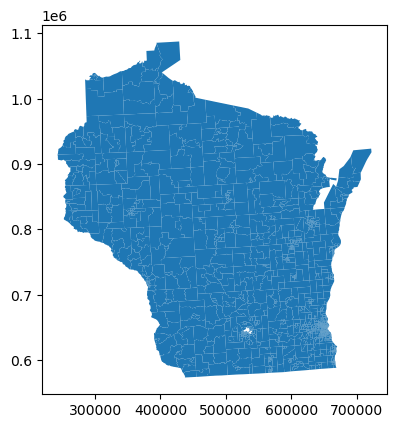

In [47]:
import geopandas 

WI_CensusTracts=geopandas.read_file('../data/WI_CensusTracts.shp')
WI_CensusTracts.plot()

In [48]:
WI_CensusTracts.columns

Index(['GEOID', 'ct_num', 'ct', 'pop', 'poverty', 'youth', 'adults', 'elderly',
       'pop_lwinc', 'white', 'black', 'native', 'asian', 'hawaiian', 'other',
       'two', 'hispanic', 'white_noh', 'no_hispani', 'white_perc',
       'black_perc', 'native_per', 'median_inc', 'mean_inc', 'hispanic_p',
       'county', 'geometry'],
      dtype='object')

In [49]:
WI_CensusTracts = WI_CensusTracts.sort_values(by=['GEOID'], ascending=True)
WI_CensusTracts = WI_CensusTracts.reset_index(drop=True) # reset the index by the sorted GEOID
WI_CensusTracts

,GEOID,ct_num,ct,pop,poverty,youth,adults,elderly,pop_lwinc,white,...,white_noh,no_hispani,white_perc,black_perc,native_per,median_inc,mean_inc,hispanic_p,county,geometry
0,55001950100,5.500195e+10,5.500195e+10,2944,148,296,1358,1290,699,2894,...,2856,2906,0.983016,0.000000,0.001019,0.0,0.0,0.012908,55001,"POLYGON ((483615.308 764584.782, 483628.857 76..."
1,55001950201,5.500195e+10,5.500195e+10,1233,118,163,714,356,389,1189,...,1189,1215,0.964315,0.000000,0.010543,0.0,0.0,0.014599,55001,"POLYGON ((477342.504 747881.102, 477345.751 74..."
2,55001950202,5.500195e+10,5.500195e+10,2584,359,377,1328,879,965,2477,...,2451,2537,0.958591,0.006192,0.009288,0.0015479876160990713,0.0,0.018189,55001,"POLYGON ((476459.321 752237.076, 476451.046 75..."
3,55001950400,5.500195e+10,5.500195e+10,4387,822,747,2600,1040,1956,4031,...,3958,4142,0.918851,0.005471,0.000000,0.02142694324139503,0.0,0.055847,55001,"POLYGON ((484380.348 739228.837, 484408.194 73..."
4,55001950501,5.500195e+10,5.500195e+10,1598,330,236,852,510,722,1557,...,1517,1548,0.974343,0.013141,0.001877,0.0,0.0,0.031289,55001,"POLYGON ((481057 732929.501, 481062.825 733118..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,55141011300,5.514101e+10,5.514101e+10,4762,316,1141,2618,1003,1794,3749,...,3654,4284,0.787274,0.004200,0.000000,0.09407811843763125,0.003149937001259975,0.100378,55141,"POLYGON ((487784.183 783646.212, 487787.992 78..."
1387,55141011400,5.514101e+10,5.514101e+10,4852,485,968,2472,1412,1551,4607,...,4524,4769,0.949505,0.011129,0.004534,0.0068013190436933225,0.0,0.017106,55141,"POLYGON ((490955.098 786545.286, 490953.172 78..."
1388,55141011500,5.514101e+10,5.514101e+10,5850,180,1248,3449,1153,767,5771,...,5771,5850,0.986496,0.001026,0.000000,0.010769230769230769,0.0,0.000000,55141,"POLYGON ((492178.542 781897.459, 492404.855 78..."
1389,55141011600,5.514101e+10,5.514101e+10,4976,655,809,3175,992,1492,4914,...,4899,4961,0.987540,0.006029,0.000000,0.0,0.0,0.003014,55141,"POLYGON ((484196.045 773530.989, 484195.139 77..."


In [52]:
## Join the geopandas dataframe of WI census tracts layer with the community detection/spatial clustering results
import pandas as pd
label_df = pd.DataFrame(labels, columns=['cluster'])
join_result = WI_CensusTracts.join(label_df)
join_result

,GEOID,ct_num,ct,pop,poverty,youth,adults,elderly,pop_lwinc,white,...,no_hispani,white_perc,black_perc,native_per,median_inc,mean_inc,hispanic_p,county,geometry,cluster
0,55001950100,5.500195e+10,5.500195e+10,2944,148,296,1358,1290,699,2894,...,2906,0.983016,0.000000,0.001019,0.0,0.0,0.012908,55001,"POLYGON ((483615.308 764584.782, 483628.857 76...",2
1,55001950201,5.500195e+10,5.500195e+10,1233,118,163,714,356,389,1189,...,1215,0.964315,0.000000,0.010543,0.0,0.0,0.014599,55001,"POLYGON ((477342.504 747881.102, 477345.751 74...",7
2,55001950202,5.500195e+10,5.500195e+10,2584,359,377,1328,879,965,2477,...,2537,0.958591,0.006192,0.009288,0.0015479876160990713,0.0,0.018189,55001,"POLYGON ((476459.321 752237.076, 476451.046 75...",7
3,55001950400,5.500195e+10,5.500195e+10,4387,822,747,2600,1040,1956,4031,...,4142,0.918851,0.005471,0.000000,0.02142694324139503,0.0,0.055847,55001,"POLYGON ((484380.348 739228.837, 484408.194 73...",7
4,55001950501,5.500195e+10,5.500195e+10,1598,330,236,852,510,722,1557,...,1548,0.974343,0.013141,0.001877,0.0,0.0,0.031289,55001,"POLYGON ((481057 732929.501, 481062.825 733118...",7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,55141011300,5.514101e+10,5.514101e+10,4762,316,1141,2618,1003,1794,3749,...,4284,0.787274,0.004200,0.000000,0.09407811843763125,0.003149937001259975,0.100378,55141,"POLYGON ((487784.183 783646.212, 487787.992 78...",2
1387,55141011400,5.514101e+10,5.514101e+10,4852,485,968,2472,1412,1551,4607,...,4769,0.949505,0.011129,0.004534,0.0068013190436933225,0.0,0.017106,55141,"POLYGON ((490955.098 786545.286, 490953.172 78...",2
1388,55141011500,5.514101e+10,5.514101e+10,5850,180,1248,3449,1153,767,5771,...,5850,0.986496,0.001026,0.000000,0.010769230769230769,0.0,0.000000,55141,"POLYGON ((492178.542 781897.459, 492404.855 78...",2
1389,55141011600,5.514101e+10,5.514101e+10,4976,655,809,3175,992,1492,4914,...,4961,0.987540,0.006029,0.000000,0.0,0.0,0.003014,55141,"POLYGON ((484196.045 773530.989, 484195.139 77...",2


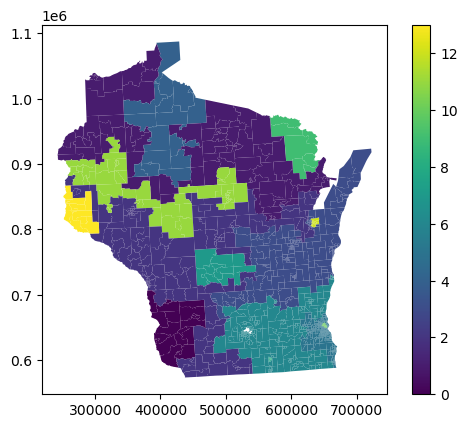

In [56]:
join_result.plot(column="cluster", legend=True); ## community detection result map